## <center><span style="font-family: Virgil GS, sans-serif; color:#a7fe01">Balancing Risk and Profit</span></center>

<span style="font-family: Virgil GS, sans-serif; color:navyblue">Author: <a href="https://github.com/deburky" title="GitHub link">https://github.com/deburky</a></span>

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
plt.rcParams['font.family'] = 'Virgil GS'

In [2]:
url= 'https://drive.google.com/file/d/1Is8UZnPRExI-SLJMle8GRbFGpha5IvYZ/view?usp=sharing'
url='https://drive.google.com/uc?id=' + url.split('/')[-2]
dataset = pd.read_csv(url, index_col=False)

In [3]:
dataset['ead'] = dataset[['balance', 'loan_amount']].max(axis=1)
dataset['loss'] = np.where(dataset['is_bad'] == 1, dataset['ead'], 0)

## <span style="font-family: Virgil GS, sans-serif; color:#a7fe01">Risk grades</span>

In [4]:
from optbinning import BinningProcess, OptimalBinning

(CVXPY) Oct 08 12:32:05 AM: Encountered unexpected exception importing solver GLOP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')
(CVXPY) Oct 08 12:32:05 AM: Encountered unexpected exception importing solver PDLP:
RuntimeError('Unrecognized new version of ortools (9.7.2996). Expected < 9.5.0.Please open a feature request on cvxpy to enable support for this version.')


In [5]:
variable = "xgb_rf_score"
x = dataset[variable].values.copy()
y = dataset['is_bad'].copy()

optb = OptimalBinning(name=variable, dtype="numerical", solver="cp")
optb.fit(x, y)

binning_table = optb.binning_table
binning_df = binning_table.build()[0:12]

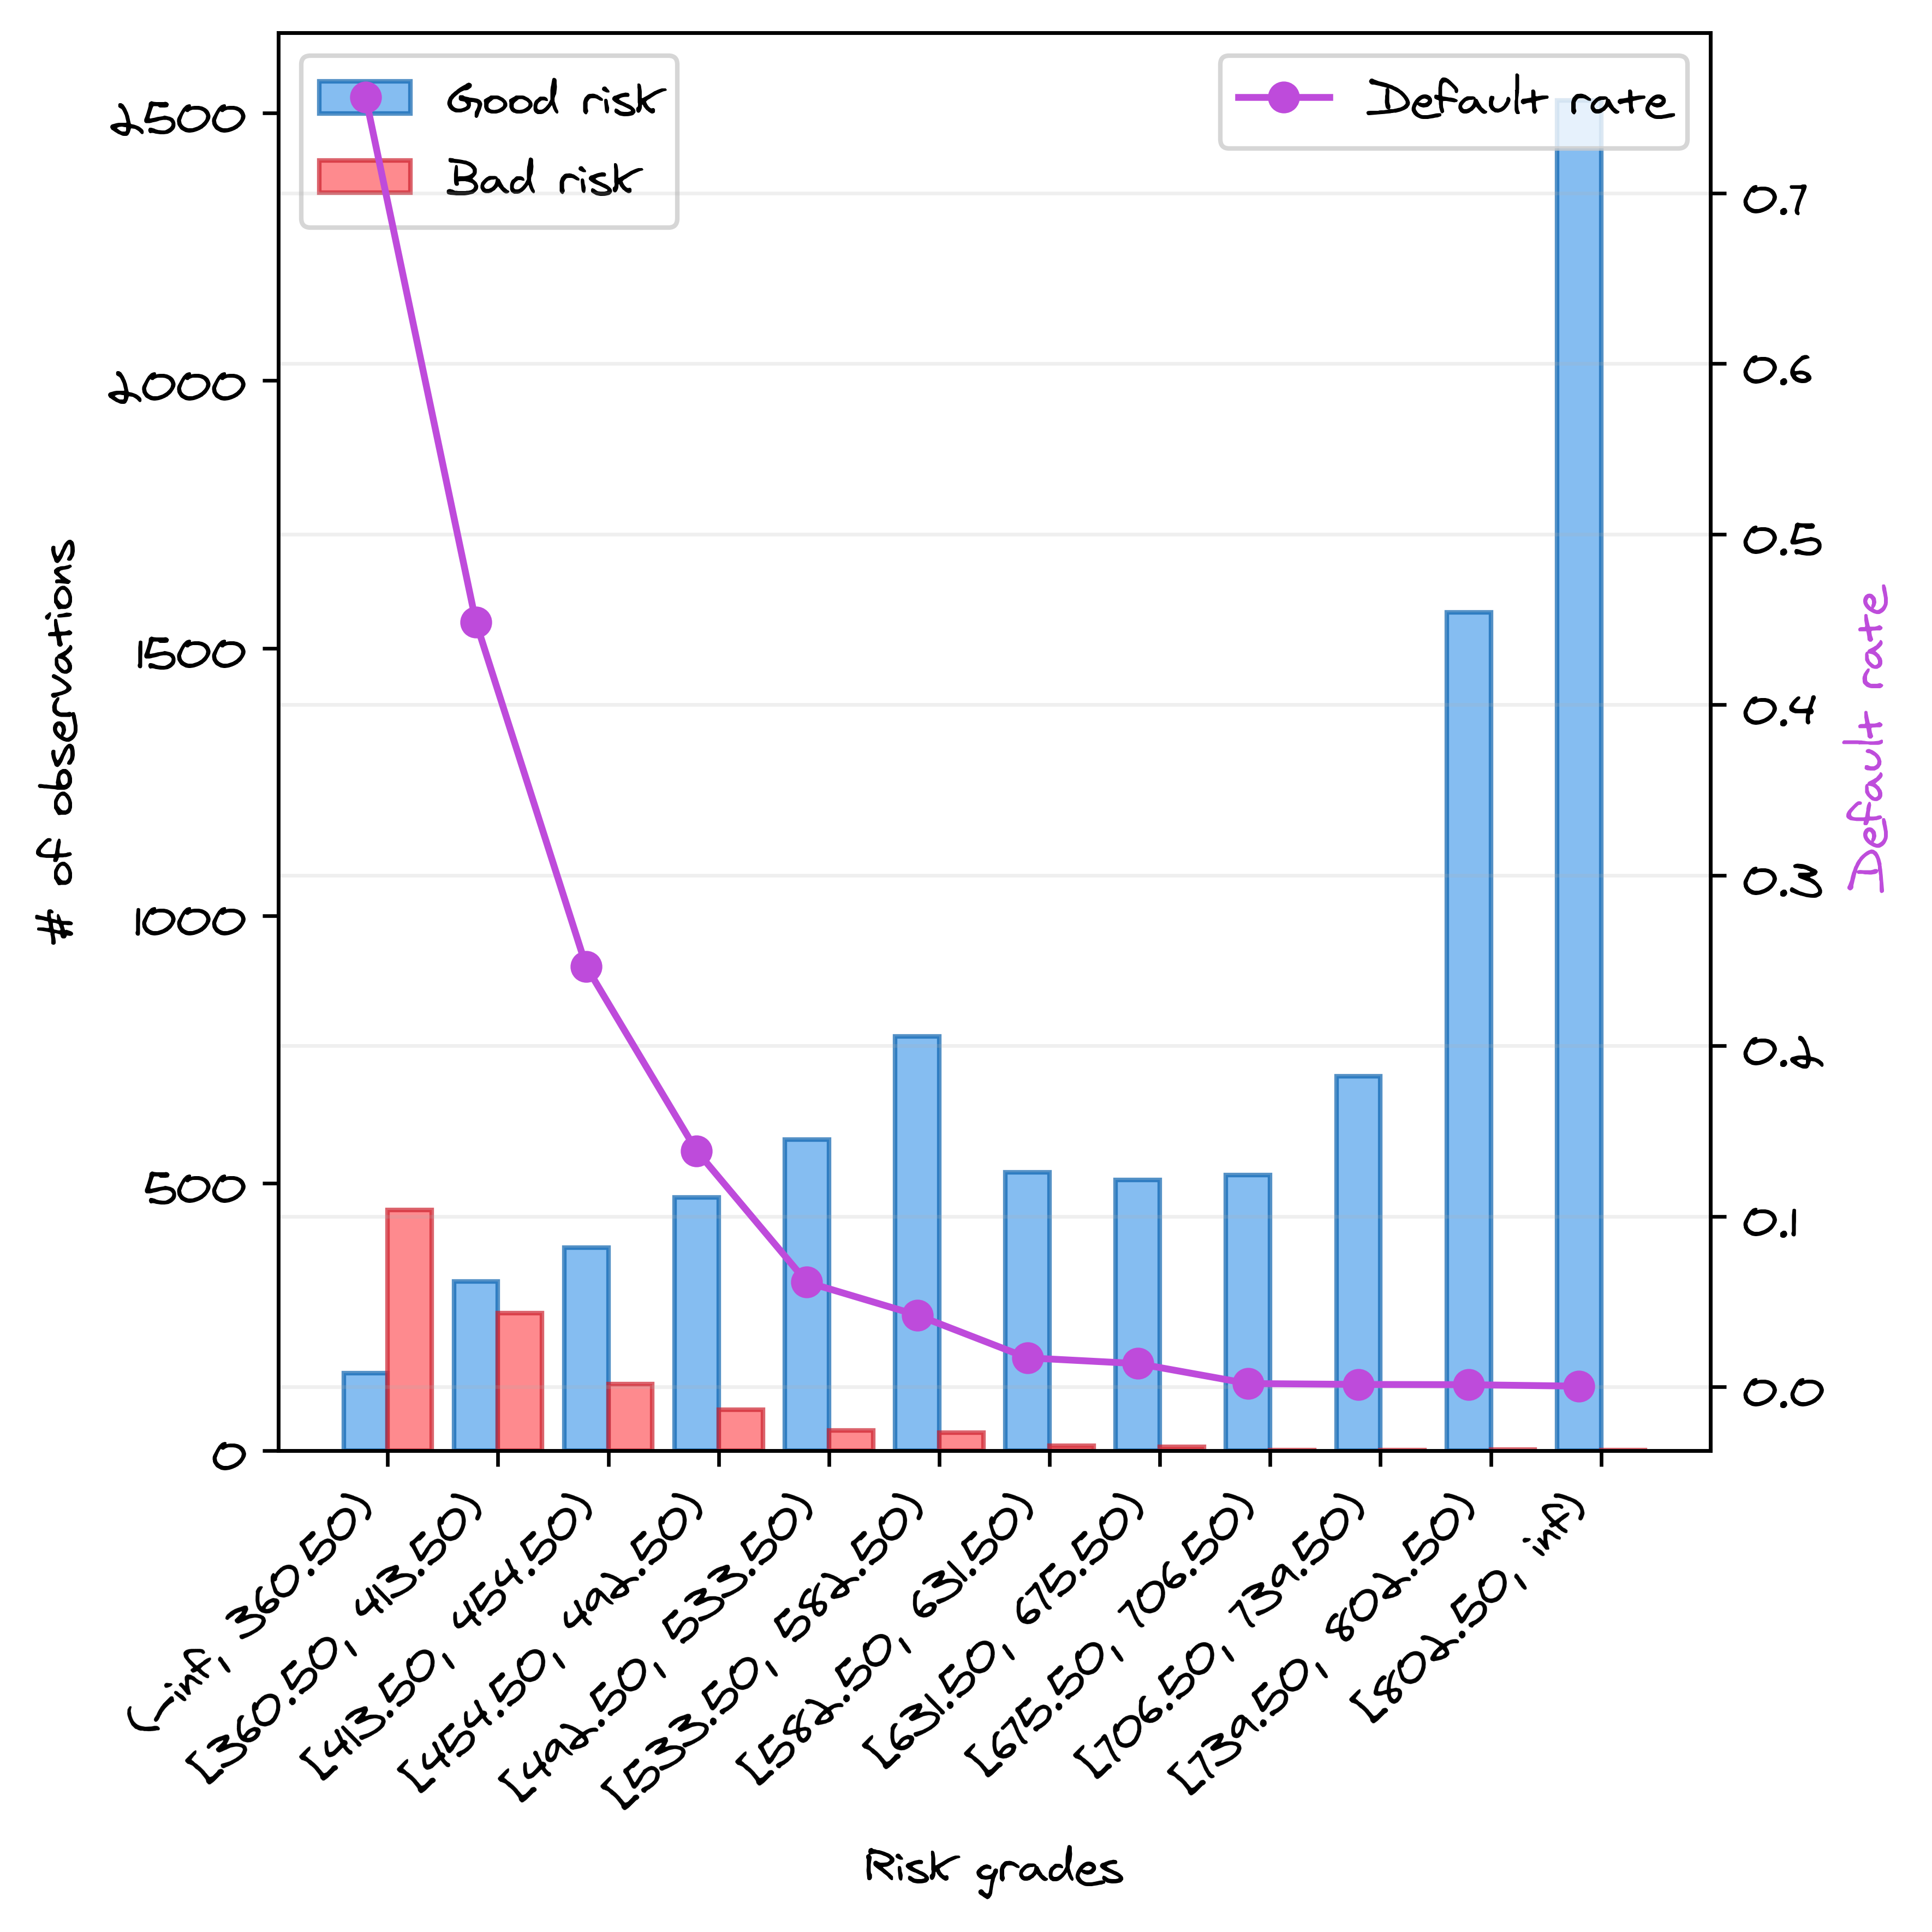

In [6]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=600)

bins, n_event, event, event_rate = \
    binning_df['Bin'], binning_df['Non-event'], binning_df['Event'], binning_df['Event rate']

# Bar chart for N-event
bar_width = 0.4
index = np.arange(len(bins))
ax1.bar(index, n_event, bar_width, label='Good risk', alpha=0.7, color='#52a1ec',
        edgecolor='#0b62af')

# Bar chart for Event
ax1.bar(index + bar_width, event, bar_width, label='Bad risk', alpha=0.7, color='#fe595f',
        edgecolor='#cc212e')

# Set the x-axis labels
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(bins, rotation=45, ha='right')

# Set labels and title
ax1.set_xlabel('Risk grades')
ax1.set_ylabel('# of observations')
# ax1.set_title('Distribution of N-event and Event by Bin')

# Create a second y-axis for Event rate as a line chart
ax2 = ax1.twinx()
ax2.plot(index, event_rate, color='#be4bdb', marker='o', 
         label='Default rate')

# Set labels for the second y-axis
ax2.set_ylabel('Default rate', color='#be4bdb')

# Add legend
ax1.legend(loc='upper left', fontsize='medium')
ax2.legend(loc='upper right', fontsize='medium')

# Display the plot
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [7]:
risk_buckets = np.round(optb.splits).copy()
[i for i in risk_buckets]

[360.0, 414.0, 454.0, 492.0, 534.0, 582.0, 632.0, 676.0, 706.0, 740.0, 802.0]

In [8]:
dataset['risk_bucket'] = np.digitize(dataset['xgb_rf_score'], risk_buckets, right=False) + 1

## <span style="font-family: Virgil GS, sans-serif; color:#a7fe01">WOE profit score</span>

In [9]:
profit_table = dataset.groupby('risk_bucket').agg(
    n_obs = ('is_bad', 'count'),
    n_bads = ('is_bad', 'sum'),
    bad_rate = ('is_bad', 'mean'),
    profits = ('paid_total', 'sum'),
    losses = ('loss', 'sum'),
    ead = ('ead', 'sum'),  
)

In [10]:
profit_table['profits'] = round(profit_table['profits'])
profit_table['n_goods'] = profit_table['n_obs'] - profit_table['n_bads']

In [11]:
profit_df = pd.DataFrame(profit_table.reset_index())
profit_df.index.name = 'risk_bucket'

# Calculate total profit and total loss
total_profit = profit_df['profits'].sum()
total_loss = profit_df['losses'].sum()

# Calculate percentage of profit and loss for each risk bucket
profit_df['share_profit'] = (profit_df['profits'] / total_profit)
profit_df['share_loss'] = (profit_df['losses'] / total_loss)

profit_df['risk_score_cut'] = pd.DataFrame({'risk_score_cut': risk_buckets})

In [12]:
profit_df['risk_score_cut'] = pd.DataFrame({'risk_score_cut': np.append(risk_buckets,1000)})

In [13]:
profit_df['woe_profit'] = np.log(profit_df['share_profit'] / profit_df['share_loss'])
profit_df['dr_logit'] = np.log((1-profit_df['bad_rate'])/profit_df['bad_rate'])
profit_df['profit_rate'] = 1 / (1 + np.exp(-(profit_df['woe_profit'])))
profit_df.reset_index(drop=True, inplace=True)

In [14]:
profit_df[['risk_score_cut', 'profit_rate']]

,risk_score_cut,profit_rate
0,360.0,0.122868
1,414.0,0.165083
2,454.0,0.286283
3,492.0,0.398628
4,534.0,0.602596
5,582.0,0.723747
6,632.0,0.797472
7,676.0,0.895486
8,706.0,0.957221
9,740.0,0.971004


In [15]:
profit_df['avg_profit'] = profit_df['share_profit'] # / profit_df['n_goods']
profit_df['avg_loss'] = profit_df['share_loss']  #/ profit_df['n_bads']

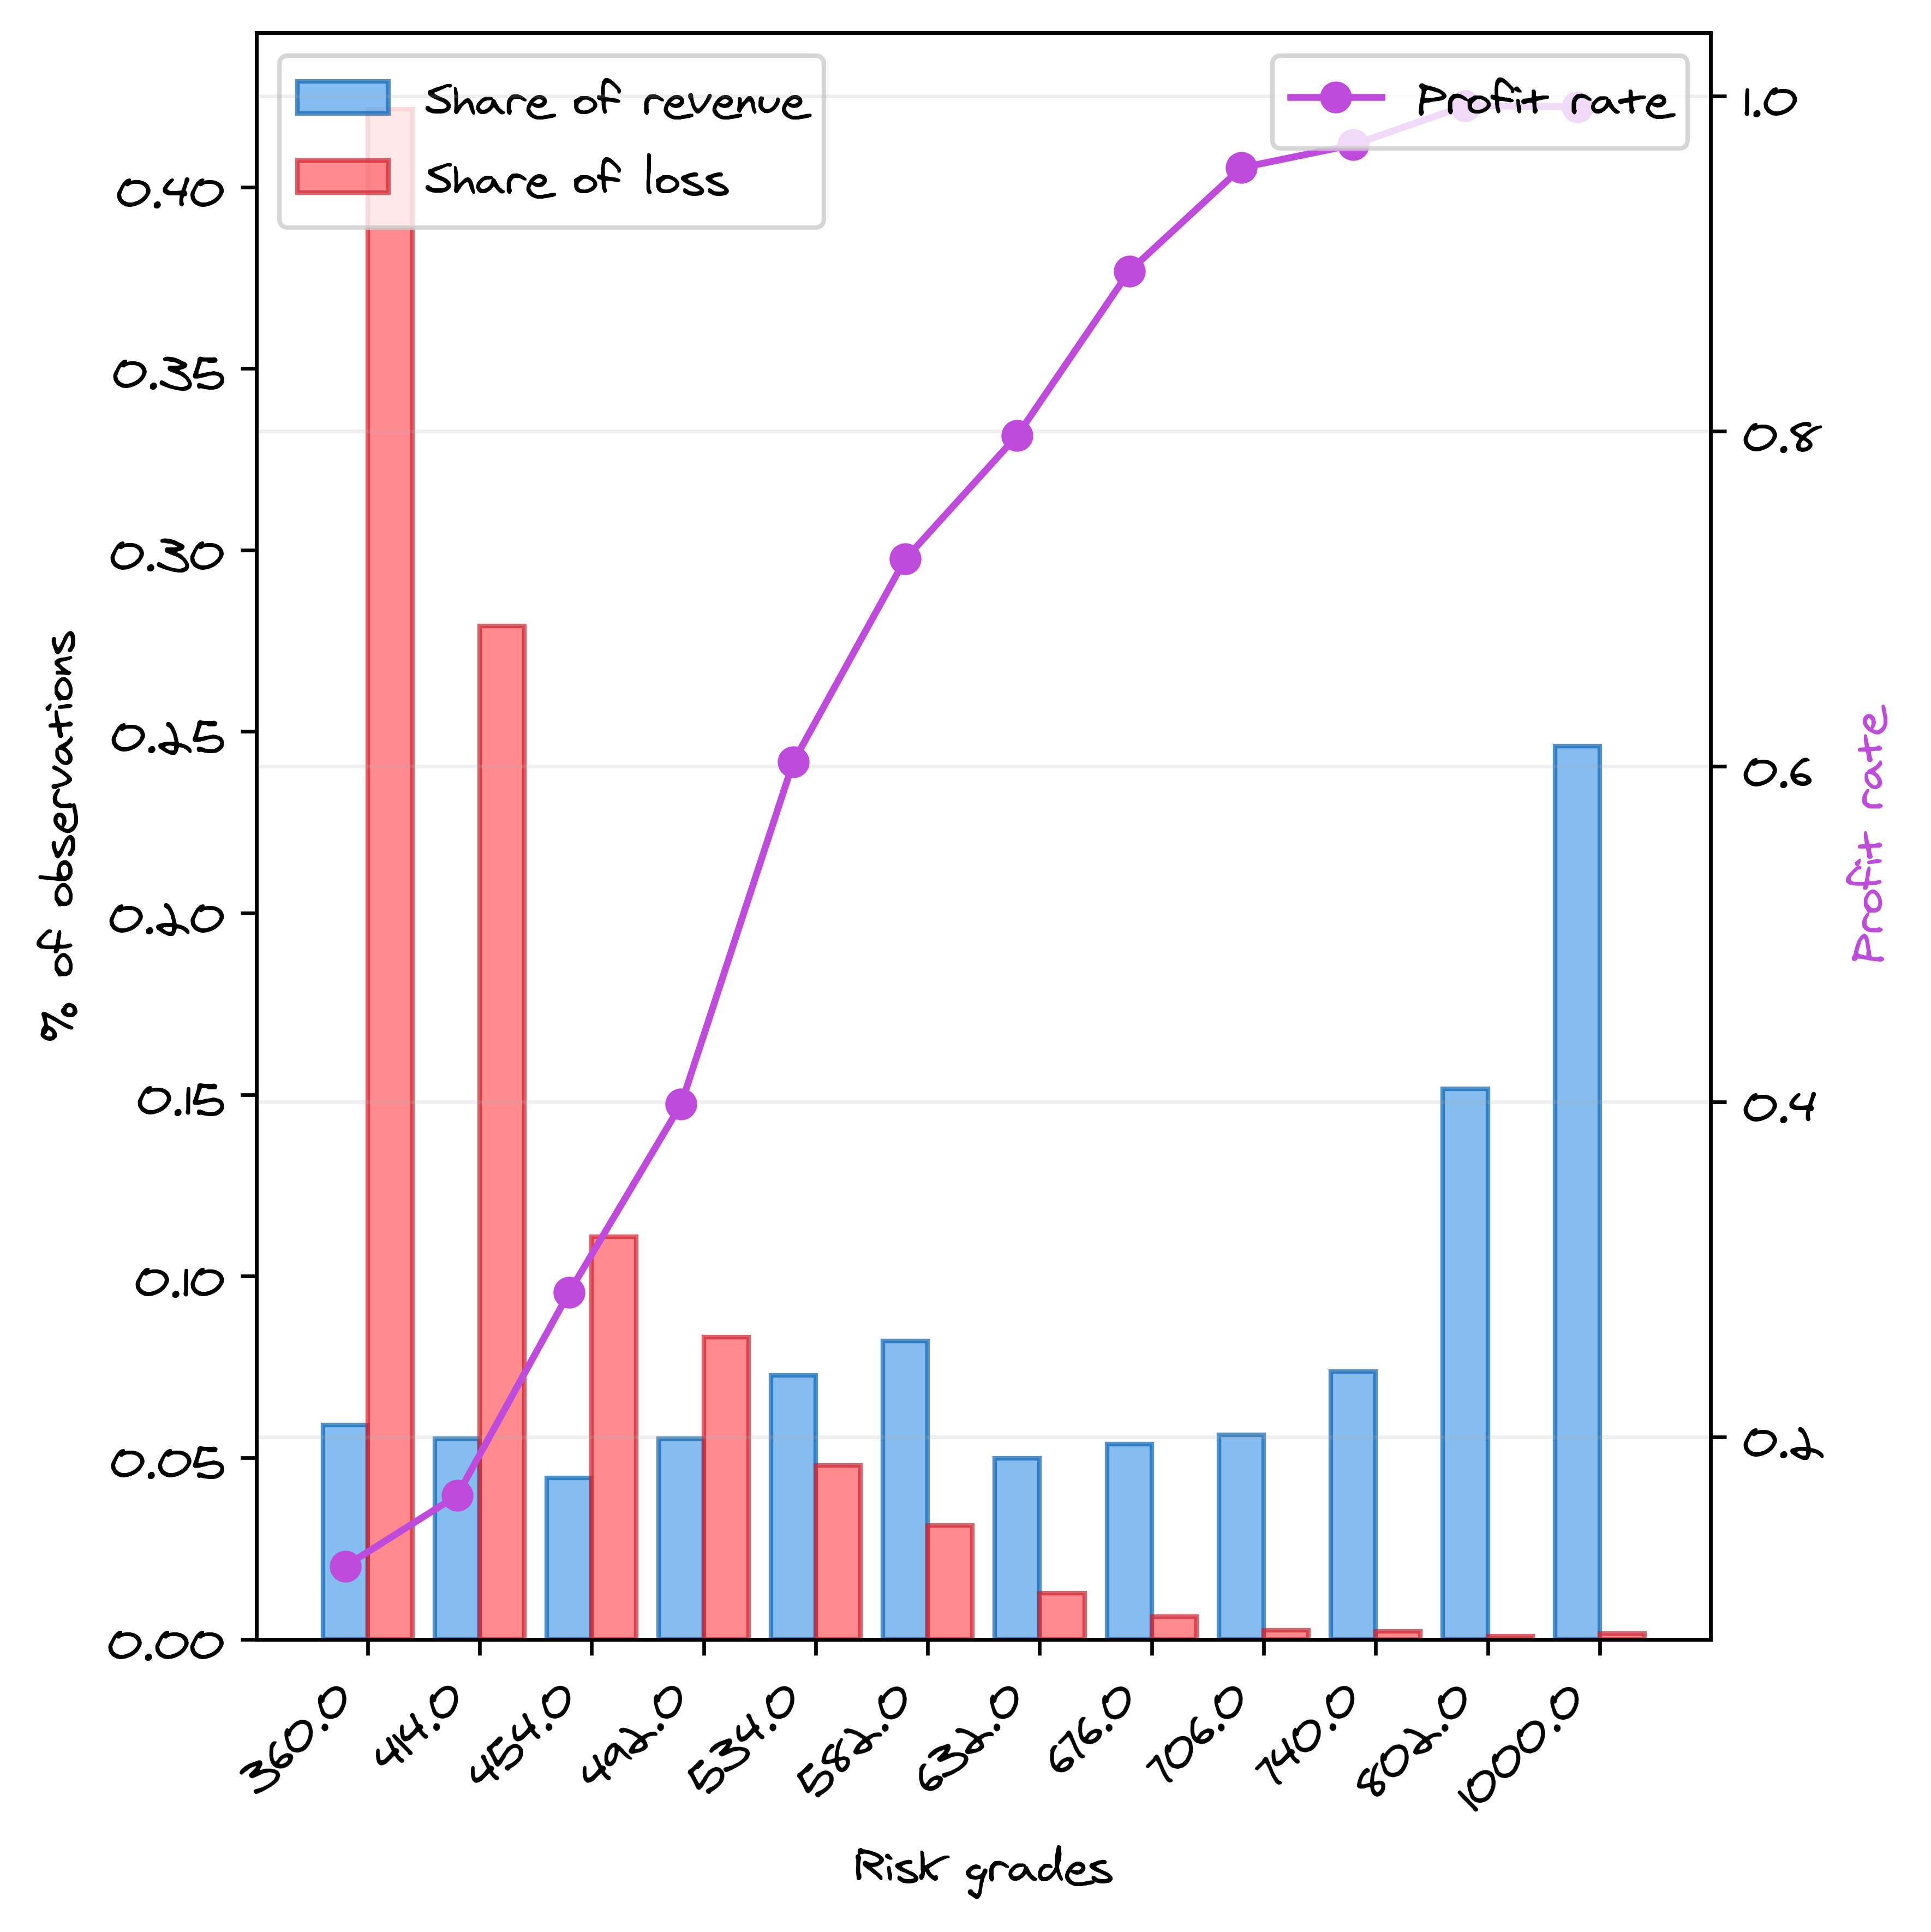

In [16]:
# Create figure and axis
fig, ax1 = plt.subplots(figsize=(6, 6), dpi=600)

bins, n_event, event, event_rate = \
    profit_df['risk_score_cut'], profit_df['avg_profit'], profit_df['avg_loss'], profit_df['profit_rate']

# Bar chart for N-event
bar_width = 0.4
index = np.arange(len(bins))
ax1.bar(index, n_event, bar_width, label='Share of revenue', alpha=0.7, color='#52a1ec',
        edgecolor='#0b62af')

# Bar chart for Event
ax1.bar(index + bar_width, event, bar_width, label='Share of loss', alpha=0.7, color='#fe595f',
        edgecolor='#cc212e')

# Set the x-axis labels
ax1.set_xticks(index + bar_width / 2)
ax1.set_xticklabels(bins, rotation=45, ha='right')

# Set labels and title
ax1.set_xlabel('Risk grades')
ax1.set_ylabel('% of observations')
# ax1.set_title('Distribution of N-event and Event by Bin')

# Create a second y-axis for Event rate as a line chart
ax2 = ax1.twinx()
ax2.plot(index, event_rate, color='#be4bdb', marker='o', 
         label='Profit rate')

# Set labels for the second y-axis
ax2.set_ylabel('Profit rate', color='#be4bdb')

# Add legend
ax1.legend(loc='upper left', fontsize='medium')
ax2.legend(loc='upper right', fontsize='medium')

# Display the plot
plt.grid(alpha=0.2)
plt.tight_layout()
plt.show()

In [17]:
# add column to dataset
dataset_mapped = pd.merge(
    dataset, profit_df[['risk_bucket', 'profit_rate']],
    left_on='risk_bucket', right_on='risk_bucket', how='left')

## <span style="font-family: Virgil GS, sans-serif; color:#a7fe01">Model training</span>

In [18]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import r2_score
import xgboost as xgb
from xgboost import XGBRFRegressor
from scipy.stats import somersd

In [19]:
dataset_training = dataset.copy()

In [20]:
dataset_training['ead'] = dataset[['balance', 'loan_amount']].max(axis=1)
dataset_training['loss'] = np.where(dataset_training['is_bad'] == 1, dataset_training['ead'], 0)
dataset_training['npv'] = dataset_training['paid_total'] - dataset_training['loss']

In [21]:
features = [
    'external_risk_estimate', 'months_since_oldest_trade_open',
       'months_since_most_recent_trade_open', 'average_months_in_file',
       'num_satisfactory_trades', 'num_trades_60_ever_2_derog_pub_rec',
       'num_trades_90_ever_2_derog_pub_rec', 'percent_trades_never_delq',
       'months_since_most_recent_delq', 'num_trades_open_in_last_12m',
       'months_since_most_recent_inqexcl7days', 'num_inq_last_6m',
       'num_inq_last_6m_excl7days', 'net_fraction_revolving_burden',
       'net_fraction_install_burden',
       'num_bank_2_natl_trades_w_high_utilization', 'debt_to_income',
       'emp_length', 'loan_amount', 'total_credit_limit',
       'current_installment_accounts', 'paid_total', 'num_mort_accounts',
       'account_never_delinq_percent', 'balance',
       'num_historical_failed_to_pay', 'num_total_cc_accounts',
       'num_cc_carrying_balance', 'age', 'monthly_income',
       'number_of_dependents', 'number_real_estate_loans_or_lines',
       'revolving_utilization_of_unsecured_lines'
]

In [22]:
X = dataset_training[features + ['npv']].copy()
y = X.pop('npv')
X.replace([-9, -8, -7], np.nan, inplace=True)

ix_train, ix_test = train_test_split(
    X.index,
    test_size=0.3,
    random_state=62
    )

In [23]:
params = {
  "colsample_bynode": 0.8,
  "learning_rate": 1,
  "max_depth": 5,
  "num_parallel_tree": 100,
  "missing": np.nan,
  "subsample": 0.8,
  "tree_method": "hist",
}

xgb_model = XGBRFRegressor(**params)
xgb_model.fit(
    X.loc[ix_train], y.loc[ix_train], 
    eval_set=[(X.loc[ix_test], y.loc[ix_test])],
    verbose=False
    )

XGBRFRegressor(base_score=None, booster=None, callbacks=None,
               colsample_bylevel=None, colsample_bytree=None,
               early_stopping_rounds=None, enable_categorical=False,
               eval_metric=None, feature_types=None, gamma=None, gpu_id=None,
               grow_policy=None, importance_type=None,
               interaction_constraints=None, learning_rate=1, max_bin=None,
               max_cat_threshold=None, max_cat_to_onehot=None,
               max_delta_step=None, max_depth=5, max_leaves=None,
               min_child_weight=None, missing=nan, monotone_constraints=None,
               n_estimators=100, n_jobs=None, num_parallel_tree=100,
               objective='reg:squarederror', predictor=None, random_state=None, ...)

In [24]:
r2_score(y.loc[ix_train], xgb_model.predict(X.loc[ix_train])),\
r2_score(y.loc[ix_test], xgb_model.predict(X.loc[ix_test]))

(0.5942133954502611, 0.573066800502269)

In [25]:
table = np.histogram2d(
    xgb_model.predict(X.loc[ix_test]).ravel(),
    y.loc[ix_test].ravel(),
    bins=50,
    )[0]
res = somersd(pd.DataFrame(table))
res.statistic

0.530812355899692

In [26]:
dataset_training['npv_score'] = xgb_model.predict(dataset_training[features])

### Curves

In [27]:
def power_curves_data(df, trend, npv_column):
    df_sorted = df.sort_values(by=npv_column, ascending=trend)
    thresholds = df_sorted[npv_column].unique()
    observations = []
    cumulative_profits = []
    cumulative_losses = []

    for threshold in thresholds:
        subset = df_sorted[df_sorted[npv_column] <= threshold]
        n_obs = subset[npv_column].count()
        cumulative_profit = subset['paid_total'].sum()
        cumulative_loss = subset['loss'].sum()
        
        observations.append(n_obs)
        cumulative_profits.append(cumulative_profit)
        cumulative_losses.append(cumulative_loss)
        
    non_cumulative_profits = sorted(cumulative_profits, reverse=True)
        
    df_out = pd.DataFrame({
        'observations': observations,
        'cumulative_profit': cumulative_profits,
        'cumulative_loss': cumulative_losses, 
        'ideal_profit': non_cumulative_profits    
    })

    return df_out

In [28]:
df_profit = power_curves_data(dataset_training, 0, 'npv_score').reset_index()
df_profit['profit'] = 1 - (df_profit['cumulative_profit'] / df_profit['cumulative_profit'].max())
# df_new['profit'].plot(x='observations')
df_profit['index'] = df_profit['index'] + 1
df_profit['index'] = df_profit['index']/df_profit['index'].max()
# Assuming df_new contains your ROC curve data
x_profit = df_profit['index'].values
y_profit = df_profit['profit'].values

# Calculate the AUC
auc_profit = np.trapz(y_profit, x_profit)

print("ROC AUC:", auc_profit)

ROC AUC: 0.6894049240440623


In [29]:
df_loss = power_curves_data(dataset_training, 1, 'npv_score').reset_index()
df_loss['loss'] = df_loss['cumulative_loss'] / df_loss['cumulative_loss'].max()
# # df_new['profit'].plot(x='observations')
df_loss['index'] = df_loss['index'] + 1
df_loss['index'] = df_loss['index']/df_loss['index'].max()
# # Assuming df_new contains your ROC curve data
x_loss = df_loss['index'].values
y_loss = df_loss['loss'].values
# # Calculate the AUC
auc_loss = np.trapz(y_loss, x_loss)
print("ROC AUC:", auc_loss)

ROC AUC: 0.8094588201799704


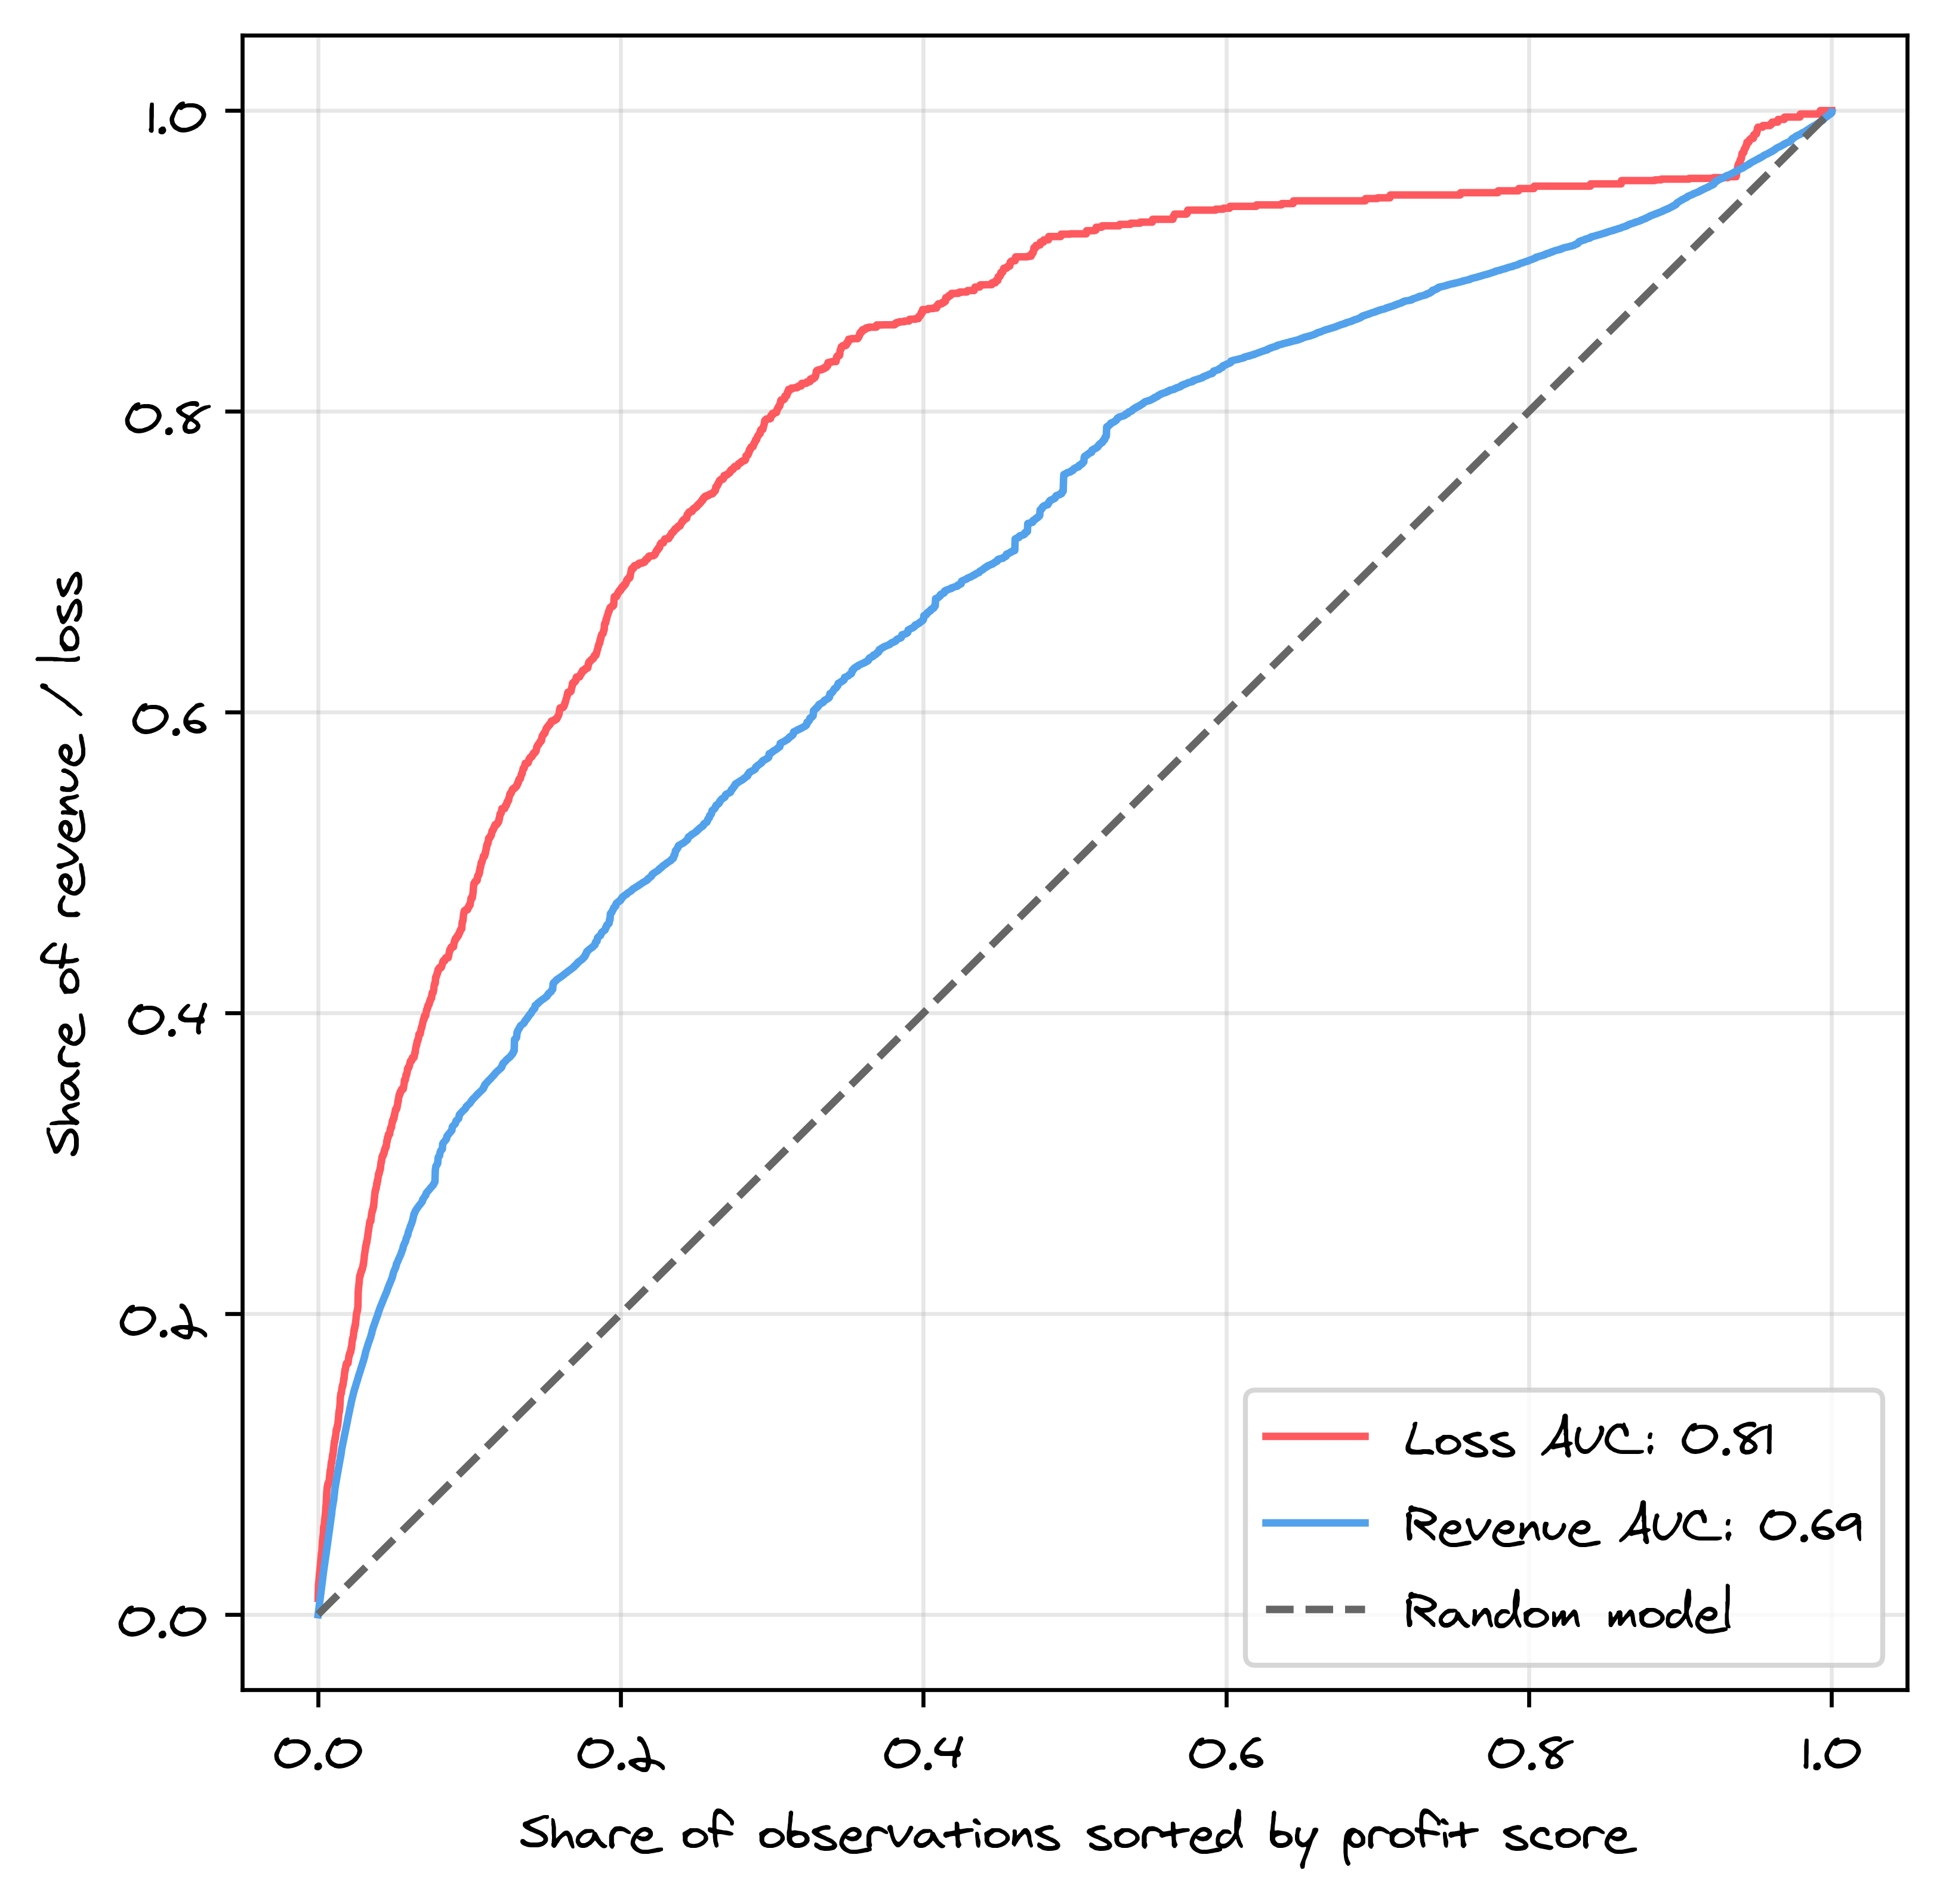

In [30]:
plt.figure(figsize=(6, 6), dpi=600)
colors = plt.get_cmap("Dark2")

plt.plot(x_loss, y_loss, color='#fe595f', label=f"Loss AUC: {auc_loss:.2f}")
plt.plot(x_profit, y_profit, color='#52a1ec', label=f"Revenue AUC: {auc_profit:.2f}")
plt.plot(x_loss, df_loss['index'], color=colors(10), linestyle='--', label='Random model')
plt.grid(alpha=0.3)
plt.xlabel('Share of observations sorted by profit score')
plt.ylabel('Share of revenue / loss')
plt.legend()
plt.show()